## Exploratory Data Analysis

In [1]:
# import libraries
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division




import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go


In [2]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install chart_studio

In [3]:
#Import Data
parse_dates = ['order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'shipping_limit_date',
'review_creation_date',
 'review_answer_timestamp',]

OL_Data = pd.read_csv("./OL_Data_Order_Grouped.csv", 
                      parse_dates=parse_dates,
                      date_parser = pd.to_datetime)



OL_Data.dtypes


Unnamed: 0                                int64
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
shipping_limit_date              datetime64[ns]
payment_installments                    float64
product_category_name_english            object
seller_id                                object
seller_zip_code_prefix                  float64
seller_city                              object
seller_state                             object
seller_latitude                         float64
seller_longitude                        float64
customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                           

<div class="span5 alert alert-info">
<h2>RFM Scoring</h2>
</div>

<h4>Functions</h4>

In [4]:
from sklearn.cluster import KMeans

def PrintKmeansInertiaGraph(dataFrame, column):
    PrintKmeansInertiaGraphWithArray(dataFrame, [column])
    
def PrintKmeansInertiaGraphWithArray(dataFrame, columns):
    sse={}
    columnDF = dataFrame[columns]
    
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(columnDF)
        columnDF.assign(clusters=kmeans.labels_)
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.show()
    
def PerformKMeans(dataFrame, column, numClusters):
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(dataFrame[[column]])
    clusterCol = '{0}Cluster'.format(column)
    clusters = kmeans.predict(dataFrame[[column]])
    if(clusterCol in dataFrame.columns):
        dataFrame.loc[:,clusterCol] = clusters
    else:
        dataFrame[clusterCol] = clusters
    
def PerformKMeansWithArray(dataFrame, columns, numClusters, clusterName):
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(dataFrame[columns])
    clusterCol = '{0}'.format(clusterName)
    clusters = kmeans.predict(dataFrame[columns])
    print(kmeans.cluster_centers_)
    
    
    if(clusterCol in dataFrame.columns):
        dataFrame.loc[:,clusterCol] = clusters
    else:
        dataFrame[clusterCol] = clusters
        
    
    
#function for ordering cluster numbers
def clustersInOrder(clusterName, targetName, dataFrame, ascending):
    
    #Set New Labels on Clusters, 0-max in order of mean targetName Value
    df_new = dataFrame.groupby(clusterName)[targetName].mean().reset_index()
    df_new = df_new.sort_values(by=targetName,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    
    #Set New Labels of Clusters to 
    df_final = pd.merge(dataFrame,df_new[[clusterName,'index']], on=clusterName)
    df_final = df_final.drop([clusterName],axis=1)
    df_final = df_final.rename(columns={"index":clusterName})
    
    return df_final

<div class="span5 alert alert-info">
<h3>Buyers</h3>
</div>

<h4>Recency</h4>

count    94467.000000
mean       241.859888
std        152.702590
min          0.000000
25%        118.000000
50%        223.000000
75%        350.000000
max        728.000000
Name: Buyer_Recency, dtype: float64


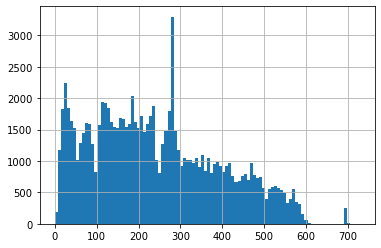

In [5]:
#Recency Score Calc
buyers = pd.DataFrame(OL_Data['customer_unique_id'].unique())
buyers.columns=['CustomerUniqueID']

buyerMaxPurchase = OL_Data.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
buyerMaxPurchase.columns = ['CustomerUniqueID', 'MaxPurchaseDate']

buyerMaxPurchase['Buyer_Recency'] = (buyerMaxPurchase['MaxPurchaseDate'].max() - buyerMaxPurchase['MaxPurchaseDate']).dt.days

buyers = pd.merge(buyers, buyerMaxPurchase[['CustomerUniqueID','Buyer_Recency']])

print(buyers['Buyer_Recency'].describe())
buyers.Buyer_Recency.sort_values().hist(bins=100)
plt.show()


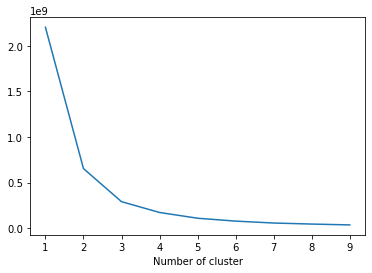

In [6]:
PrintKmeansInertiaGraph(buyers,'Buyer_Recency')

In [7]:
#Generate Recency Clusters, named 'RecencyCluster'
PerformKMeans(buyers,'Buyer_Recency', 4)

#Reset Cluster Names, Lower Recency = More Recent, Higher RecencyCluster
buyers = clustersInOrder('Buyer_RecencyCluster', 'Buyer_Recency', buyers, False)

<h4>Frequency</h4>

count    94467.000000
mean         1.061005
std          0.289504
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: Buyer_Frequency, dtype: float64


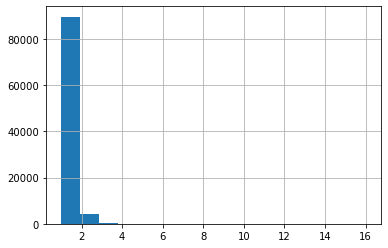

In [8]:
#Frequency
freq = OL_Data.groupby('customer_unique_id').order_id.count().reset_index()
freq.columns = ['CustomerUniqueID','Buyer_Frequency']
freq.head()

buyers = pd.merge(buyers,freq, on='CustomerUniqueID')

print(buyers['Buyer_Frequency'].describe())
buyers.Buyer_Frequency.sort_values().hist(bins=16)
plt.show()

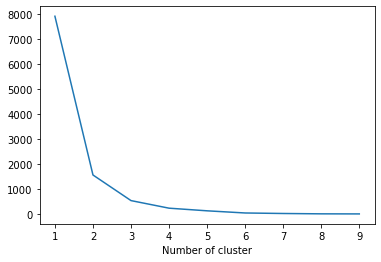

In [9]:
PrintKmeansInertiaGraph(buyers,'Buyer_Frequency')

In [10]:
#Generate Recency Clusters, named 'FrequencyCluster'
PerformKMeans(buyers,'Buyer_Frequency', 4)

#Reset Cluster Names, Higher Frequency = More Frequent, Higher Frequency Cluster
buyers = clustersInOrder('Buyer_FrequencyCluster', 'Buyer_Frequency', buyers, True)

<h4>Revenue</h4>

count    94467.000000
mean       182.890726
std        306.673979
min          0.000000
25%         63.230000
50%        108.840000
75%        188.340000
max      13664.080000
Name: Buyer_Revenue, dtype: float64


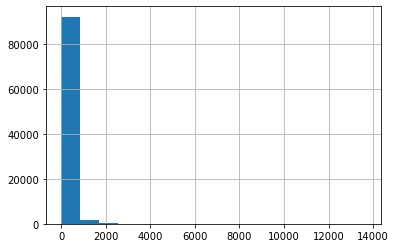

In [11]:
#Revenue
rev = OL_Data.groupby('customer_unique_id').Total_payment.sum().reset_index()
rev.columns = ['CustomerUniqueID','Buyer_Revenue']

buyers = pd.merge(buyers, rev, on='CustomerUniqueID')

print(buyers['Buyer_Revenue'].describe())
buyers.Buyer_Revenue.sort_values().hist(bins=16)
plt.show()

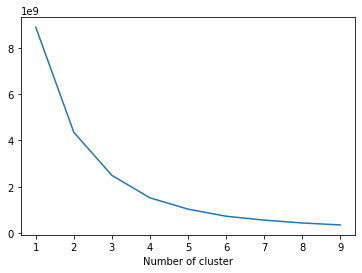

In [12]:
PrintKmeansInertiaGraph(buyers,'Buyer_Revenue')

In [13]:
#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(buyers,'Buyer_Revenue', 5)

#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
buyers = clustersInOrder('Buyer_RevenueCluster', 'Buyer_Revenue', buyers, True)

<h4>Scale RFM and Cluster</h4>

In [14]:
sub = buyers[['Buyer_Recency','Buyer_Frequency','Buyer_Revenue','CustomerUniqueID']]

sub = sub.assign(scale_recency=sub.apply(lambda x: 1 - x['Buyer_Recency']/sub['Buyer_Recency'].max(),axis=1))
sub = sub.assign(scale_frequency=sub.apply(lambda x: x['Buyer_Frequency']/sub['Buyer_Frequency'].max(),axis=1))
sub = sub.assign(scale_revenue=sub.apply(lambda x: x['Buyer_Revenue']/sub['Buyer_Revenue'].max(),axis=1))

sub = sub.assign(Buyer_Overall_RFM_Scaled =sub.apply(lambda x: x['scale_recency']+x['scale_frequency']+x['scale_revenue'],axis=1))

sub.columns

Index(['Buyer_Recency', 'Buyer_Frequency', 'Buyer_Revenue', 'CustomerUniqueID',
       'scale_recency', 'scale_frequency', 'scale_revenue',
       'Buyer_Overall_RFM_Scaled'],
      dtype='object')

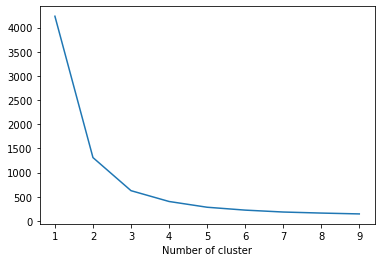

In [15]:
PrintKmeansInertiaGraphWithArray(sub,['scale_recency','scale_frequency','scale_revenue'])

In [16]:
PerformKMeansWithArray(sub, ['scale_recency','scale_frequency','scale_revenue'], 6, 'Buyer_RFM_cluster')

sub.groupby('Buyer_RFM_cluster')[['scale_recency','scale_frequency','scale_revenue']].mean().reset_index()

buyers = buyers.merge(sub[['Buyer_RFM_cluster','CustomerUniqueID','Buyer_Overall_RFM_Scaled']], on='CustomerUniqueID')

[[0.59387593 0.0661918  0.0135161 ]
 [0.82129266 0.06667508 0.01408188]
 [0.44495376 0.06622673 0.01315986]
 [0.93741538 0.06673832 0.01366393]
 [0.71339513 0.06621488 0.0124997 ]
 [0.27919818 0.06544045 0.01331295]]


In [17]:
print(buyers.columns)
buyers = clustersInOrder('Buyer_RFM_cluster', 'Buyer_Overall_RFM_Scaled', buyers, True)

Index(['CustomerUniqueID', 'Buyer_Recency', 'Buyer_RecencyCluster',
       'Buyer_Frequency', 'Buyer_FrequencyCluster', 'Buyer_Revenue',
       'Buyer_RevenueCluster', 'Buyer_RFM_cluster',
       'Buyer_Overall_RFM_Scaled'],
      dtype='object')


<h4>Alternative RFM Clustering, sum RFM for overall score</h4>

In [18]:
#calculate overall score and use mean() to see details
buyers['Buyer_OverallRFMScore'] = buyers['Buyer_RecencyCluster'] + buyers['Buyer_FrequencyCluster'] + buyers['Buyer_RevenueCluster']
buyers['Buyer_OverallRFM_Raw'] = buyers['Buyer_Recency'] + buyers['Buyer_Frequency'] + buyers['Buyer_Revenue']

print(buyers.groupby('Buyer_OverallRFMScore')[['Buyer_Recency','Buyer_Frequency','Buyer_Revenue']].mean())

print(buyers.groupby('Buyer_OverallRFMScore')[['Buyer_Revenue']].count())

                       Buyer_Recency  Buyer_Frequency  Buyer_Revenue
Buyer_OverallRFMScore                                               
0                         486.650868         1.000000      99.080974
1                         335.620489         1.012424     125.333156
2                         211.650303         1.029909     147.637506
3                          96.431351         1.047355     171.845733
4                         111.000651         1.300195     483.854825
5                         110.057961         1.698867     894.013518
6                         103.953157         2.207739    1487.894868
7                         102.946667         2.866667    2482.782800
8                          85.833333         4.208333    3333.663125
9                          75.555556         4.333333    4164.014444
                       Buyer_Revenue
Buyer_OverallRFMScore               
0                              13714
1                              21973
2                       

In [19]:
#Assign labels
buyers['Buyer_RFM_Ranking'] = '0-Lowest'
buyers.loc[buyers['Buyer_OverallRFMScore']>=1,'Buyer_RFM_Ranking'] ='1-Low' 
buyers.loc[buyers['Buyer_OverallRFMScore']>=3, 'Buyer_RFM_Ranking'] = '2-Medium'
buyers.loc[buyers['Buyer_OverallRFMScore']>=6, 'Buyer_RFM_Ranking'] = '3-High'
buyers.loc[buyers['Buyer_OverallRFMScore']>=8, 'Buyer_RFM_Ranking'] = '4-Highest'

In [20]:
buyers.head()

,CustomerUniqueID,Buyer_Recency,Buyer_RecencyCluster,Buyer_Frequency,Buyer_FrequencyCluster,Buyer_Revenue,Buyer_RevenueCluster,Buyer_Overall_RFM_Scaled,Buyer_RFM_cluster,Buyer_OverallRFMScore,Buyer_OverallRFM_Raw,Buyer_RFM_Ranking
0,7c396fd4830fd04220f754e42b4e5bff,335,1,2,1,82.82,0,0.670896,2,2,419.82,1-Low
1,7973a6ba9c81ecaeb3d628c33c7c7c48,348,1,2,1,115.74,0,0.655448,2,2,465.74,1-Low
2,0a5df23b922b9998bb7378f1ac03c98a,338,1,2,1,193.83,0,0.674900,2,2,533.83,1-Low
3,95cfb39a7e263160308a934e42cfc4e0,287,1,2,1,122.05,0,0.739701,2,2,411.05,1-Low
4,646d643b4ac1184e383341f8896c3dc8,286,1,2,1,178.04,0,0.745173,2,2,466.04,1-Low


<div class="span5 alert alert-info">
<h3>Sellers</h3>
</div>

<h4>Recency</h4>

count    2977.000000
mean      134.126638
std       163.831359
min         0.000000
25%        17.000000
50%        46.000000
75%       210.000000
max       699.000000
Name: Seller_Recency, dtype: float64


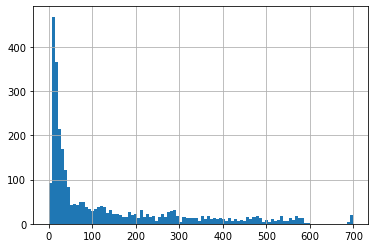

In [21]:
#Recency Score Calc
sellers = pd.DataFrame(OL_Data['seller_id'].unique())
sellers.columns=['SellerID']

sellerMaxSale = OL_Data.groupby('seller_id').order_purchase_timestamp.max().reset_index()
sellerMaxSale.columns = ['SellerID', 'MaxSaleDate']

sellerMaxSale['Seller_Recency'] = (sellerMaxSale['MaxSaleDate'].max() - sellerMaxSale['MaxSaleDate']).dt.days

sellers = pd.merge(sellers, sellerMaxSale[['SellerID','Seller_Recency']])

print(sellers['Seller_Recency'].describe())
sellers.Seller_Recency.sort_values().hist(bins=100)
plt.show()

<h4>Frequency</h4>

count    2977.000000
mean       33.667786
std       108.081772
min         1.000000
25%         2.000000
50%         7.000000
75%        22.000000
max      1865.000000
Name: Seller_Frequency, dtype: float64


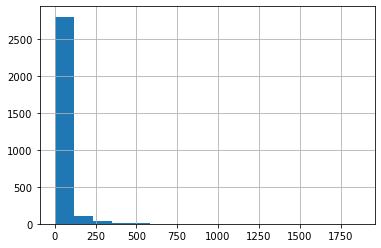

In [22]:
#Frequency
freq = OL_Data.groupby('seller_id').order_id.count().reset_index()
freq.columns = ['SellerID','Seller_Frequency']
freq.head()

sellers = pd.merge(sellers,freq, on='SellerID')

print(sellers['Seller_Frequency'].describe())
sellers.Seller_Frequency.sort_values().hist(bins=16)
plt.show()

<h4>Revenue</h4>

count      2977.000000
mean       5803.513779
std       17929.475314
min          15.220000
25%         315.440000
50%        1164.380000
75%        4533.870000
max      301542.650000
Name: Seller_Revenue, dtype: float64


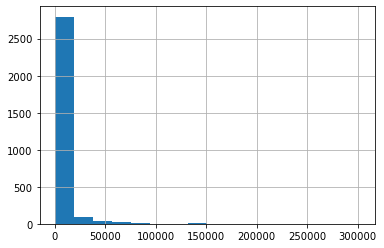

In [23]:
#Revenue
rev = OL_Data.groupby('seller_id').Total_payment.sum().reset_index()
rev.columns = ['SellerID','Seller_Revenue']

sellers = pd.merge(sellers, rev, on='SellerID')

print(sellers['Seller_Revenue'].describe())
sellers.Seller_Revenue.sort_values().hist(bins=16)
plt.show()

Seller_Recency


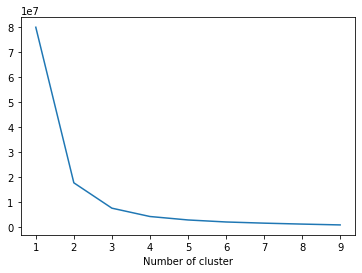


Seller_Frequency


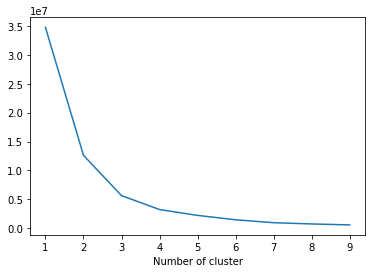


Seller_Revenue


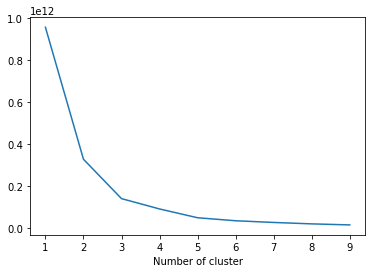

In [24]:
print('Seller_Recency')
PrintKmeansInertiaGraph(sellers,'Seller_Recency')
print('')
print('Seller_Frequency')
PrintKmeansInertiaGraph(sellers,'Seller_Frequency')
print('')
print('Seller_Revenue')
PrintKmeansInertiaGraph(sellers,'Seller_Revenue')

In [25]:
#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(sellers,'Seller_Recency', 4)
#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
sellers = clustersInOrder('Seller_RecencyCluster', 'Seller_Recency', sellers, False)

print(sellers.groupby('Seller_RecencyCluster').mean())

#Generate Recency Clusters, named 'FrequencyCluster'
PerformKMeans(sellers,'Seller_Frequency', 4)
#Reset Cluster Names, Higher Frequency = More Frequent, Higher Frequency Cluster
sellers = clustersInOrder('Seller_FrequencyCluster', 'Seller_Frequency', sellers, True)

#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(sellers,'Seller_Revenue', 5)
#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
sellers = clustersInOrder('Seller_RevenueCluster', 'Seller_Revenue', sellers, True)

                       Seller_Recency  Seller_Frequency  Seller_Revenue
Seller_RecencyCluster                                                  
0                          524.697842          3.859712      892.622482
1                          315.493639          9.246819     1657.918321
2                          152.221805         15.836466     3187.145432
3                           27.315671         49.096392     8276.092559


<h4>Scale RFM and Cluster</h4>

In [26]:
sub = sellers[['Seller_Recency','Seller_Frequency','Seller_Revenue','SellerID']]

sub = sub.assign(scale_recency=sub.apply(lambda x: 1 - x['Seller_Recency']/sub['Seller_Recency'].max(),axis=1))
sub = sub.assign(scale_frequency=sub.apply(lambda x: x['Seller_Frequency']/sub['Seller_Frequency'].max(),axis=1))
sub = sub.assign(scale_revenue=sub.apply(lambda x: x['Seller_Revenue']/sub['Seller_Revenue'].max(),axis=1))

sub = sub.assign(Seller_Overall_RFM_Scaled =sub.apply(lambda x: x['scale_recency']+x['scale_frequency']+x['scale_revenue'],axis=1))


sub.head()

,Seller_Recency,Seller_Frequency,Seller_Revenue,SellerID,scale_recency,scale_frequency,scale_revenue,Seller_Overall_RFM_Scaled
0,300,53,3177.71,3504c0cb71d7fa48d967e0e4c94d59d9,0.570815,0.028418,0.010538,0.609772
1,345,6,1125.49,633ecdf879b94b5337cca303328e4a25,0.506438,0.003217,0.003732,0.513387
2,277,10,2062.45,f5f46307a4d15880ca14fab4ad9dfc9b,0.603720,0.005362,0.006840,0.615921
3,339,26,2462.81,c8417879a15366a17c30af34c798c332,0.515021,0.013941,0.008167,0.537130
4,284,40,2870.32,6df688df543f90e9b38f4319e75a9d88,0.593705,0.021448,0.009519,0.624672


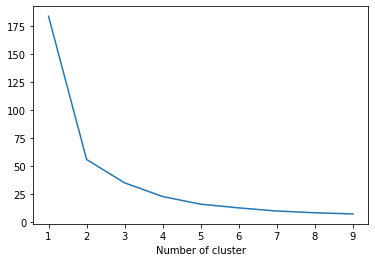

In [27]:
PrintKmeansInertiaGraphWithArray(sub,['scale_recency','scale_frequency','scale_revenue'])

In [28]:
PerformKMeansWithArray(sub, ['scale_recency','scale_frequency','scale_revenue'], 5, 'Seller_RFM_cluster')
sellers = sellers.merge(sub[['Seller_RFM_cluster','SellerID','Seller_Overall_RFM_Scaled']], on='SellerID')

sellers['Seller_OverallRFMScore'] = sellers['Seller_RecencyCluster'] + sellers['Seller_FrequencyCluster'] + sellers['Seller_RevenueCluster']
sellers['Seller_OverallRFM_Raw'] = sellers['Seller_Recency'] + sellers['Seller_Frequency'] + sellers['Seller_Revenue']
sellers.columns

[[0.24935931 0.00206955 0.00296019]
 [0.96054261 0.01992295 0.02085481]
 [0.54865002 0.00495808 0.00549812]
 [0.98053119 0.52421028 0.54908409]
 [0.78195805 0.00799332 0.00966882]]


Index(['SellerID', 'Seller_Recency', 'Seller_Frequency', 'Seller_Revenue',
       'Seller_RecencyCluster', 'Seller_FrequencyCluster',
       'Seller_RevenueCluster', 'Seller_RFM_cluster',
       'Seller_Overall_RFM_Scaled', 'Seller_OverallRFMScore',
       'Seller_OverallRFM_Raw'],
      dtype='object')

In [29]:
sellers = clustersInOrder('Seller_RFM_cluster', 'Seller_Overall_RFM_Scaled', sellers, True)

<h4>Alternative RFM Clustering, sum RFM for overall score</h4>

In [30]:
#calculate overall score and use mean() to see details
sellers['Seller_OverallRFMScore'] = sellers['Seller_RecencyCluster'] + sellers['Seller_FrequencyCluster'] + sellers['Seller_RevenueCluster']
print(sellers.groupby('Seller_OverallRFMScore')[['Seller_Recency','Seller_Frequency','Seller_Revenue']].mean())

print(sellers.groupby('Seller_OverallRFMScore')[['Seller_Revenue']].count())

                        Seller_Recency  Seller_Frequency  Seller_Revenue
Seller_OverallRFMScore                                                  
0                           525.327273          3.523636      739.880145
1                           316.021053          7.076316     1218.973632
2                           157.008081          9.024242     1696.893111
3                            32.586010         13.621699     2286.891742
4                            34.474860         61.318436    13190.084749
5                            22.658228        127.575949    19882.175759
6                            22.560976        232.658537    46439.367073
7                            14.851852        425.074074    53798.847037
8                            22.625000        638.875000   128986.017500
9                             7.375000       1187.125000   175086.316250
10                           10.600000       1252.600000   254983.110000
                        Seller_Revenue
Seller_Overa

In [31]:
sellers['Seller_RFM_Ranking'] = '0-Lowest'
sellers.loc[sellers['Seller_OverallRFMScore']>=1,'Seller_RFM_Ranking'] ='1-Low' 
sellers.loc[sellers['Seller_OverallRFMScore']>=4, 'Seller_RFM_Ranking'] = '2-Medium'
sellers.loc[sellers['Seller_OverallRFMScore']>=6, 'Seller_RFM_Ranking'] = '3-High'

<h4>Merge in RFM Clusters</h4>

In [32]:
OL_Data = OL_Data.merge(buyers, left_on='customer_unique_id', right_on='CustomerUniqueID')
OL_Data = OL_Data.merge(sellers, left_on='seller_id',right_on='SellerID')
OL_Data.columns

Index(['Unnamed: 0', 'order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'shipping_limit_date', 'payment_installments',
       'product_category_name_english', 'seller_id', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'seller_latitude', 'seller_longitude',
       'customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'customer_latitude',
       'customer_longitude', 'review_id', 'review_score',
       'review_creation_date', 'review_answer_timestamp', 'Total_price',
       'number_of_items', 'Median_payments', 'Total_payment', 'Total_Freight',
       'order_weight_g', 'order_volume_cm3', 'payment_type',
       'Purchase_To_Delivery_Days', 'Approved_To_Delivery_Days',
       'Diff_Est_Delivery_vs_Actual', 'CustomerUniqueID', 'Buyer_Recency',
       'Buyer_RecencyCluster', 'Bu

<h3>Add Distance from Buyer to Seller</h3>

In [33]:
#calculate Distance Between Two Points on Earth
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
     
     
OL_Data['DistanceOfSale'] = OL_Data.apply(lambda x: distance(x.customer_latitude, x.customer_longitude, x.seller_latitude, x.seller_longitude) , axis=1)

In [34]:
OL_Data['DistanceOfSale'].describe()

count    99727.000000
mean       603.487296
std        596.949713
min          0.000000
25%        189.670210
50%        435.533645
75%        801.451936
max       8736.947618
Name: DistanceOfSale, dtype: float64

<h3>Write out data</h3>

In [35]:
OL_Data.to_csv('./OLData_RFM_Metrics.csv')

['1-Low' '0-Lowest' '2-Medium' '3-High' '4-Highest']


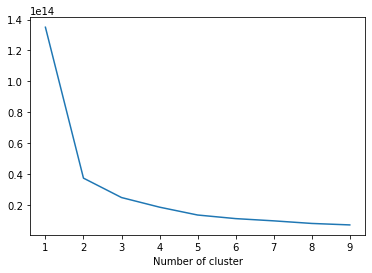

[[ 3.07694593e+00 -2.28056125e+01 -4.68713334e+01 -2.06746112e+01
  -4.58166922e+01  3.81966726e+00  1.23974593e+02  1.16785502e+00
   1.43234314e+02  1.49894970e+02  1.99655437e+01  2.53431313e+03
   1.98692261e+04  1.37929293e+01  1.33169935e+01 -1.05540701e+01
   4.40637350e+02  1.55218933e+05  3.93820559e+00  6.27062028e+02]
 [ 2.74906071e+00 -2.28433874e+01 -4.73774662e+01 -2.07941309e+01
  -4.59510961e+01  3.73060444e+00  1.12315787e+02  1.13011667e+00
   1.31673583e+02  1.35961489e+02  2.02949318e+01  2.05023697e+03
   1.52744163e+04  1.44413684e+01  1.39649331e+01 -1.01788939e+01
   4.11820715e+02  2.31242294e+04  2.81688748e+00  6.48133999e+02]
 [ 3.95726496e+00 -2.17516502e+01 -4.74776469e+01 -2.12395981e+01
  -4.57986108e+01  3.53768454e+00  1.49042012e+02  1.11810412e+00
   1.71456472e+02  1.77032852e+02  2.28191142e+01  4.26803419e+03
   2.97456061e+04  1.74576535e+01  1.69930070e+01 -8.31313131e+00
   4.59032960e+02  2.73548148e+05  4.00000000e+00  5.79787819e+02]]
Index(

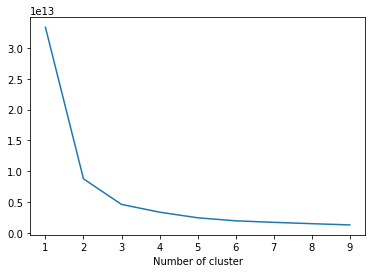

[[ 2.71503897e+00 -2.29581866e+01 -4.72119204e+01 -2.07230240e+01
  -4.61020626e+01  3.94062357e+00  7.85278909e+01  1.10087116e+00
   9.62035603e+01  9.80688973e+01  1.85177350e+01  1.68399450e+03
   1.32049904e+04  1.28053645e+01  1.23846859e+01 -1.41529115e+01
   5.90170227e+02  2.06543091e+04  2.39798258e+00  6.53812185e+02]
 [ 2.99507995e+00 -2.30077920e+01 -4.67384512e+01 -2.09531710e+01
  -4.58996418e+01  4.08364084e+00  8.96027306e+01  1.05412054e+00
   1.06909397e+02  1.07952804e+02  1.76771218e+01  2.33291144e+03
   1.75113407e+04  1.09151292e+01  1.05276753e+01 -1.46285363e+01
   5.94159446e+02  1.45046536e+05  3.88929889e+00  6.08223948e+02]
 [ 3.55319149e+00 -2.23876186e+01 -4.79299122e+01 -2.11522205e+01
  -4.60669733e+01  3.71124620e+00  1.11250608e+02  1.04255319e+00
   1.29278191e+02  1.31450061e+02  2.06750456e+01  3.99675684e+03
   3.19858450e+04  1.53039514e+01  1.48844985e+01 -1.09452888e+01
   6.05413587e+02  2.81473310e+05  4.00000000e+00  5.98720618e+02]]
Index(

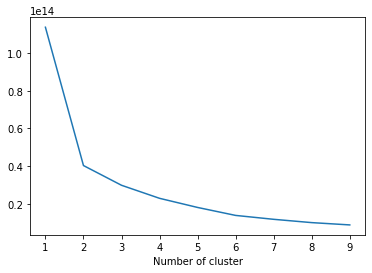

[[ 3.74303074e+00 -2.22715160e+01 -4.67993925e+01 -2.02794126e+01
  -4.56032664e+01  3.75196569e+00  2.08126573e+02  1.32773410e+00
   2.27591639e+02  2.65054446e+02  2.70139278e+01  4.12120872e+03
   2.79628417e+04  1.19135096e+01  1.14488921e+01 -1.17819871e+01
   4.66150658e+02  1.99964699e+05  4.00000000e+00  6.28854193e+02]
 [ 3.22080249e+00 -2.27056225e+01 -4.72195694e+01 -2.10629512e+01
  -4.60964818e+01  3.81682898e+00  1.89812638e+02  1.25866771e+00
   2.13354710e+02  2.34970646e+02  2.64347487e+01  2.88840226e+03
   1.96221533e+04  1.06213479e+01  1.01709388e+01 -1.23906506e+01
   4.05420630e+02  2.12558055e+04  2.95005843e+00  6.12956912e+02]]
Index(['payment_installments', 'seller_latitude', 'seller_longitude',
       'customer_latitude', 'customer_longitude', 'review_score',
       'Total_price', 'number_of_items', 'Median_payments', 'Total_payment',
       'Total_Freight', 'order_weight_g', 'order_volume_cm3',
       'Purchase_To_Delivery_Days', 'Approved_To_Delivery_Days

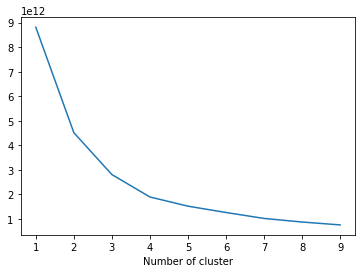

[[ 4.75191424e+00 -2.27933044e+01 -4.73966607e+01 -2.11233458e+01
  -4.61323169e+01  3.09954058e+00  4.31290245e+02  2.17611026e+00
   4.46016478e+02  7.29212052e+02  3.96901072e+01  3.40678714e+03
   2.15609724e+04  9.64624809e+00  9.20214395e+00 -1.67473201e+01
   1.74822395e+03  2.56161635e+04  2.93108729e+00  6.50471338e+02]
 [ 4.59183673e+00 -2.22547340e+01 -4.72969841e+01 -2.04926195e+01
  -4.58300943e+01  3.07482993e+00  3.16231224e+02  2.04761905e+00
   3.47629490e+02  6.72128299e+02  4.67736735e+01  6.05217007e+03
   4.14992381e+04  1.03129252e+01  9.73469388e+00 -1.47006803e+01
   1.70794340e+03  2.06274887e+05  4.00000000e+00  6.40675452e+02]
 [ 8.50000000e+00 -2.34712450e+01 -4.63995254e+01 -1.86356667e+01
  -4.25802795e+01  2.33333333e+00  8.75158333e+02  7.50000000e+00
   1.48039167e+03  2.48662333e+03  1.31858333e+02  8.58461667e+04
   5.56691000e+05  2.43333333e+01  2.33333333e+01 -1.50000000e+01
   4.12664667e+03  1.82356590e+05  3.66666667e+00  7.68376246e+02]
 [ 5.43

C:\Users\Karl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



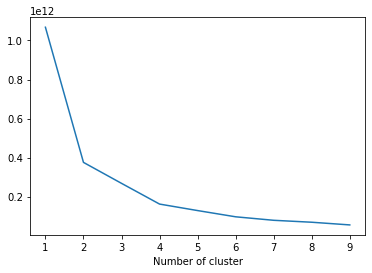

[[ 1.00000000e+00 -2.24566934e+01 -4.76553366e+01 -1.48371529e+01
  -4.57877059e+01  4.60000000e+00  5.71980000e+02  3.60000000e+00
   7.46510000e+02  1.61586200e+03  1.03918000e+02  2.69666000e+04
   1.91740000e+05  8.00000000e+00  6.20000000e+00 -1.66000000e+01
   4.58560600e+03  2.04422968e+05  4.00000000e+00  9.77987008e+02]
 [ 5.20238095e+00 -2.26838987e+01 -4.77343900e+01 -2.17016046e+01
  -4.67329994e+01  2.59523810e+00  3.61297143e+02  3.25000000e+00
   3.75803274e+02  8.54894048e+02  4.65891667e+01  4.77446429e+03
   3.12705357e+04  9.26190476e+00  8.92857143e+00 -1.96547619e+01
   3.27351357e+03  1.91978686e+04  2.90476190e+00  6.67500083e+02]
 [ 6.88235294e+00 -2.26742396e+01 -4.76283624e+01 -2.08992394e+01
  -4.41576886e+01  2.88235294e+00  2.73575294e+02  2.52941176e+00
   3.43844706e+02  6.94531765e+02  4.62064706e+01  3.70729412e+03
   3.25600588e+04  7.35294118e+00  6.88235294e+00 -1.60588235e+01
   2.22703235e+03  2.16249398e+05  4.00000000e+00  8.03249804e+02]
 [ 5.45

In [36]:
clusters={"1-Low":3,"0-Lowest":3,"2-Medium":2,"3-High":4,"4-Highest":4}

print(OL_Data['Buyer_RFM_Ranking'].unique())

for t in OL_Data['Buyer_RFM_Ranking'].unique():
    subset = OL_Data[OL_Data['Buyer_RFM_Ranking']==t]
    
    numcols = ['payment_installments',
            'seller_latitude', 
            'seller_longitude',
            'customer_latitude',
            'customer_longitude', 
            'review_score',
            'Total_price',
            'number_of_items', 
            'Median_payments', 
            'Total_payment', 
            'Total_Freight',
            'order_weight_g', 
            'order_volume_cm3', 
            'Purchase_To_Delivery_Days', 
            'Approved_To_Delivery_Days',
            'Diff_Est_Delivery_vs_Actual',
            'Buyer_OverallRFM_Raw',
            'Seller_OverallRFM_Raw', 
            'Seller_RFM_cluster',
            'DistanceOfSale']
    
    test = numcols+['order_id']
    subset = subset[test].dropna()
    
    
    PrintKmeansInertiaGraphWithArray(subset,numcols)
    PerformKMeansWithArray(subset, numcols, clusters[t], "{0}-SubClusers".format(t))
    print(subset.columns)
    OL_Data.merge(subset[['order_id',"{0}-SubClusers".format(t)]], on='order_id')
    

In [37]:
OL_Data.columns

Index(['Unnamed: 0', 'order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'shipping_limit_date', 'payment_installments',
       'product_category_name_english', 'seller_id', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'seller_latitude', 'seller_longitude',
       'customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'customer_latitude',
       'customer_longitude', 'review_id', 'review_score',
       'review_creation_date', 'review_answer_timestamp', 'Total_price',
       'number_of_items', 'Median_payments', 'Total_payment', 'Total_Freight',
       'order_weight_g', 'order_volume_cm3', 'payment_type',
       'Purchase_To_Delivery_Days', 'Approved_To_Delivery_Days',
       'Diff_Est_Delivery_vs_Actual', 'CustomerUniqueID', 'Buyer_Recency',
       'Buyer_RecencyCluster', 'Bu

In [38]:

AllOrderLines = []
for index, row in OL_Data.iterrows():
    originRow = {}
    destRow = {}
    
    originRow['Origin-Destination'] = 'Origin'
    destRow['Origin-Destination'] = 'Destination'

    idName = "{0}-{1}".format(row['customer_id'],index)
    originRow['PathId'] = idName
    destRow['PathId'] = idName

    originRow['Latitude'] = row['seller_latitude']
    originRow['Longitude'] = row['seller_longitude']
    destRow['Latitude'] = row['customer_latitude']
    destRow['Longitude'] =  row['customer_longitude']
    
    originRow['Buyer_RFM_Ranking'] = row['Buyer_RFM_Ranking']
    destRow['Buyer_RFM_Ranking'] = row['Buyer_RFM_Ranking']    
    originRow['Seller_RFM_Ranking'] = row['Seller_RFM_Ranking']
    destRow['Seller_RFM_Ranking'] = row['Seller_RFM_Ranking']
    
    AllOrderLines.append(originRow)
    AllOrderLines.append(destRow)
    
mapDf = pd.DataFrame(AllOrderLines)
mapDf.to_csv('./OrderMapData.csv')

In [39]:
BuyerSellerMatrix = pd.pivot_table(OL_Data, columns=['seller_id'], index=['customer_id'],values='order_id', fill_value=0, aggfunc=len).reset_index()
BuyerCategoryMatrix = pd.pivot_table(OL_Data, columns=['product_category_name_english'], index=['customer_id'],values='order_id', fill_value=0, aggfunc=len).reset_index()
SellerCategoryMatrix = pd.pivot_table(OL_Data, columns=['product_category_name_english'], index=['seller_id'],values='order_id', fill_value=0, aggfunc=len).reset_index()

In [62]:
import warnings
warnings. filterwarnings('ignore')

def GenerateSimularityScores(dataFrame, indexName):
    values = dataFrame.loc[:, dataFrame.columns!=indexName].to_numpy()
    lfunc = lambda e: e%2;
    values = lfunc(values)
    dfDict = {indexName : list(np.transpose(dataFrame[[indexName]].to_numpy()))}
    
    for x in range(len(dataFrame[indexName])):
        
        if(x%(len(dataFrame[indexName])//1000) ==0):
            print("{0}% ".format(x/len(dataFrame[indexName])*100))
        
        seller = dataFrame[indexName][x]
        sellerCol = np.transpose(dataFrame.loc[dataFrame[indexName]==seller, dataFrame.columns!=indexName].to_numpy())

        res =np.matmul(values,sellerCol)

        dfDict[seller] = list(np.transpose(np.matmul(values,sellerCol)))
        
    simularity = pd.DataFrame(dfDict)
    simularity = simularity.set_index(indexName)
    return simularity

In [63]:
sellerCategorySimularity = GenerateSimularityScores(SellerCategoryMatrix,'seller_id')


0.0% 
0.06854009595613435% 
0.1370801919122687% 
0.205620287868403% 
0.2741603838245374% 
0.3427004797806717% 
0.411240575736806% 
0.47978067169294036% 
0.5483207676490748% 
0.616860863605209% 
0.6854009595613434% 
0.7539410555174777% 
0.822481151473612% 
0.8910212474297465% 
0.9595613433858807% 
1.0281014393420151% 
1.0966415352981496% 
1.1651816312542838% 
1.233721727210418% 
1.3022618231665526% 
1.3708019191226868% 
1.439342015078821% 
1.5078821110349554% 
1.5764222069910898% 
1.644962302947224% 
1.7135023989033584% 
1.782042494859493% 
1.8505825908156273% 
1.9191226867717615% 
1.9876627827278959% 
2.0562028786840303% 
2.1247429746401645% 
2.193283070596299% 
2.2618231665524333% 
2.3303632625085675% 
2.3989033584647017% 
2.467443454420836% 
2.5359835503769705% 
2.604523646333105% 
2.6730637422892394% 
2.7416038382453736% 
2.8101439342015078% 
2.878684030157642% 
2.9472241261137766% 
3.015764222069911% 
3.0843043180260454% 
3.1528444139821796% 
3.221384509938314% 
3.289924605894448% 

28.169979437971215% 
28.23851953392735% 
28.30705962988348% 
28.375599725839617% 
28.44413982179575% 
28.51267991775189% 
28.58122001370802% 
28.64976010966415% 
28.718300205620288% 
28.786840301576422% 
28.855380397532553% 
28.92392049348869% 
28.992460589444825% 
29.061000685400963% 
29.129540781357093% 
29.198080877313227% 
29.266620973269365% 
29.335161069225496% 
29.403701165181634% 
29.472241261137768% 
29.5407813570939% 
29.609321453050036% 
29.677861549006167% 
29.7464016449623% 
29.81494174091844% 
29.88348183687457% 
29.952021932830707% 
30.02056202878684% 
30.089102124742972% 
30.15764222069911% 
30.226182316655244% 
30.29472241261138% 
30.363262508567512% 
30.431802604523643% 
30.50034270047978% 
30.568882796435915% 
30.637422892392046% 
30.705962988348183% 
30.774503084304317% 
30.843043180260455% 
30.911583276216586% 
30.98012337217272% 
31.048663468128858% 
31.11720356408499% 
31.185743660041126% 
31.254283755997257% 
31.32282385195339% 
31.39136394790953% 
31.4599040438

56.20287868403015% 
56.27141877998629% 
56.33995887594243% 
56.40849897189856% 
56.4770390678547% 
56.545579163810835% 
56.61411925976696% 
56.682659355723096% 
56.751199451679234% 
56.819739547635365% 
56.8882796435915% 
56.95681973954764% 
57.02535983550378% 
57.0938999314599% 
57.16244002741604% 
57.23098012337218% 
57.2995202193283% 
57.36806031528444% 
57.436600411240576% 
57.50514050719671% 
57.573680603152845% 
57.64222069910898% 
57.710760795065106% 
57.779300891021244% 
57.84784098697738% 
57.91638108293352% 
57.98492117888965% 
58.05346127484579% 
58.122001370801925% 
58.19054146675805% 
58.25908156271419% 
58.327621658670324% 
58.396161754626455% 
58.46470185058259% 
58.53324194653873% 
58.601782042494854% 
58.67032213845099% 
58.73886223440713% 
58.80740233036327% 
58.8759424263194% 
58.944482522275536% 
59.01302261823167% 
59.0815627141878% 
59.150102810143935% 
59.21864290610007% 
59.287183002056196% 
59.355723098012334% 
59.42426319396847% 
59.4928032899246% 
59.56134338

86.0178204249486% 
86.08636052090472% 
86.15490061686086% 
86.223440712817% 
86.29198080877313% 
86.36052090472927% 
86.42906100068541% 
86.49760109664153% 
86.56614119259767% 
86.63468128855381% 
86.70322138450994% 
86.77176148046607% 
86.8403015764222% 
86.90884167237834% 
86.97738176833447% 
87.0459218642906% 
87.11446196024674% 
87.18300205620288% 
87.25154215215902% 
87.32008224811516% 
87.38862234407128% 
87.45716244002742% 
87.52570253598356% 
87.5942426319397% 
87.66278272789582% 
87.73132282385195% 
87.79986291980809% 
87.86840301576422% 
87.93694311172035% 
88.00548320767649% 
88.07402330363261% 
88.14256339958875% 
88.21110349554489% 
88.27964359150103% 
88.34818368745717% 
88.4167237834133% 
88.48526387936944% 
88.55380397532556% 
88.6223440712817% 
88.69088416723784% 
88.75942426319396% 
88.8279643591501% 
88.89650445510624% 
88.96504455106236% 
89.0335846470185% 
89.10212474297464% 
89.17066483893078% 
89.23920493488691% 
89.30774503084305% 
89.37628512679919% 
89.4448252

In [64]:
buyerCategorySimularity = GenerateSimularityScores(BuyerCategoryMatrix,'customer_id')


0.0% 
0.09970918155380142% 
0.19941836310760283% 
0.29912754466140423% 
0.39883672621520566% 
0.4985459077690071% 
0.5982550893228085% 
0.69796427087661% 
0.7976734524304113% 
0.8973826339842127% 
0.9970918155380142% 
1.0968009970918156% 
1.196510178645617% 
1.2962193601994183% 
1.39592854175322% 
1.4956377233070213% 
1.5953469048608226% 
1.695056086414624% 
1.7947652679684254% 
1.894474449522227% 
1.9941836310760284% 
2.0938928126298295% 
2.193601994183631% 
2.2933111757374327% 
2.393020357291234% 
2.4927295388450355% 
2.5924387203988366% 
2.692147901952638% 
2.79185708350644% 
2.891566265060241% 
2.9912754466140425% 


KeyboardInterrupt: 

In [ ]:
sellerBuyerSimularity = GenerateSimularityScores(BuyerSellerMatrix, 'customer_id')

In [ ]:
sellerCategorySimularity.to_csv('./sellerCategorySimularity.csv')
buyerCategorySimularity.to_csv('./buyerCategorySimularity.csv')
sellerBuyerSimularity.to_csv('./sellerBuyerSimularity.csv')

In [ ]:
sns.set(rc = {'figure.figsize':(500,500)})
sns.heatmap(sellerCategorySimularity, annot=False)